# Experiment on finance data

Dataset used is the currency enchange with respect to USD dollars, from daily measurements from the last 2 years (2017-2018).

Currencies used: 
- Reference: USA
- Canadian dollar (CAD)
- Euro (EUR)
- Japanese yen (JPY)
- Great british pound (GBP)
- Swiss franc (CHF)
- Austrial dollar (AUD)
- Hong Kong dollar (HKD)
- New zealand dollar (NZD)
- South korean won (KRW)
- Mexican peso (MXN)


**Question** how to treat sampling values when input is not time

---

Inflation data 
https://data.oecd.org/price/inflation-cpi.htm

In [1]:
# execute if not installed
import sys
sys.path.insert(0, '../')

import mogptk

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

%reload_ext autoreload
%autoreload 2

In [2]:
# plot config
sns.set_context('paper', font_scale=1.3)
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = (10, 5)

## Load dataset

In [58]:
df = pd.read_csv('data/finance_datasets/currency_exchange/final_dataset.csv')
cols = list(df)[3:]
cols[0], cols[1] = cols[1], cols[0]
cols

['EUR/USD',
 'CAD/USD',
 'JPY/USD',
 'GBP/USD',
 'CHF/USD',
 'AUD/USD',
 'HKD/USD',
 'NZD/USD',
 'KRW/USD',
 'MXN/USD']

In [4]:
data = []
for c in cols:
    data.append(mogptk.LoadCSV('data/finance_datasets/currency_exchange/final_dataset.csv',
                               x_cols='Day',
                               y_col=c,
                               name=c))
for d in data:
    d.transform(mogptk.TransformDetrend)

## Create and fit model

Remove data to simulate sensor failure

In [5]:
# randomly sample from the data
for channel in data:
    channel.remove_randomly(pct=0.4)

# drop chunks to simulate sensor failure

data[0].remove_range(df['Day'].iloc[-1], None)
data[1].remove_range(90, 120)
data[2].remove_range(480, 520)
data[3].remove_range(200, 250)
data[4].remove_range(None, 30)
data[5].remove_range(None, 30)
data[7].remove_range(500, 550)

for i in range(1, len(cols)):
     data[i].remove_range(650, None)

# add pred values

# use data class
x_test = [channel.X[~channel.mask] for channel in data]
y_test = [df[cols[i]].values[~data[i].mask] for i in range(len(cols))]

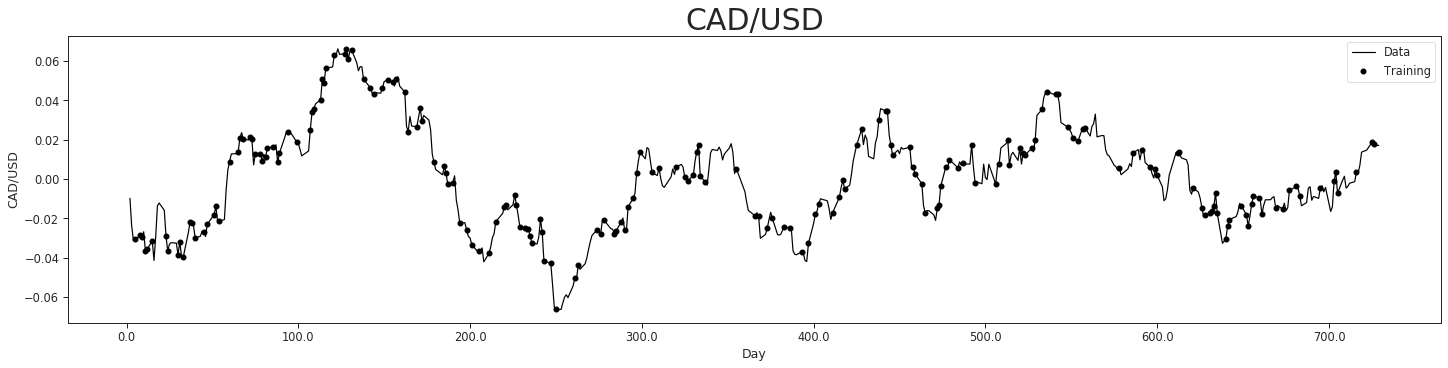

In [6]:
i = 0
data[i].plot()

## MOSM

warning!!!, long time of execution

In [7]:
n_trials = 5

mosm_mae = np.zeros((n_trials, len(cols)))
mosm_mape = np.zeros((n_trials, len(cols)))
mosm_rmse = np.zeros((n_trials, len(cols)))

for n in range(n_trials):
    model_mosm = mogptk.MOSM(data, Q=5)
    model_mosm.init_params('SM')
    
    print('Starting trial', n)
    model_mosm.train(method='L-BFGS-B', maxiter=5000, tol=1e-50)
    print('Finished trial', n)
    print('='*50)        
    
    # errors per channel
    error = mogptk.test_errors(model_mosm, x_test=x_test, y_test=y_test)
    
    mosm_mae[n, :] = np.array(error[0])[:, 0]
    mosm_mape[n, :] = np.array(error[0])[:, 1]
    mosm_rmse[n, :] = np.array(error[0])[:, 2]
    
pd.DataFrame(np.c_[mosm_mae.mean(0), mosm_mape.mean(0), mosm_rmse.mean(0),
                             mosm_mae.std(0), mosm_mape.std(0), mosm_rmse.std(0)],
                       columns=['MAE', 'MAPE', 'RMSE', 'MAE std', 'MAPE% std', 'RMSE std'])

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -671.624067
  Number of iterations: 117
  Number of functions evaluations: 212
Done in  0.03164156675338745  minutes
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -645.745911
  Number of iterations: 67
  Number of functions evaluations: 143
Done in  0.016537638505299886  minutes
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: 180.380862
  Number of iterations: 93
  Number of functions evaluations: 142
Done in  0.01690252621968587  minutes
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -624.601646
  Number of iterations: 99
  Number of functions evaluations: 121
Done in  0.016484419504801433  mi

,MAE,MAPE,RMSE,MAE std,MAPE% std,RMSE std
0,0.005063,0.391767,0.006790,0.000373,0.029354,0.000502
1,0.004384,0.501833,0.006207,0.000398,0.044443,0.000736
2,0.615078,0.551776,0.843975,0.062856,0.056366,0.088336
3,0.004078,0.531074,0.005610,0.000650,0.083714,0.001067
4,0.005321,0.538667,0.008181,0.000279,0.027944,0.000612
5,0.009388,0.695297,0.015844,0.000522,0.037733,0.001225
6,0.004159,0.053213,0.007689,0.000350,0.004476,0.000785
7,0.010256,0.710668,0.015231,0.001596,0.109875,0.003301
8,7.211995,0.642869,10.904727,1.478857,0.131666,3.138611
9,0.166378,0.849905,0.254674,0.015233,0.076025,0.028589


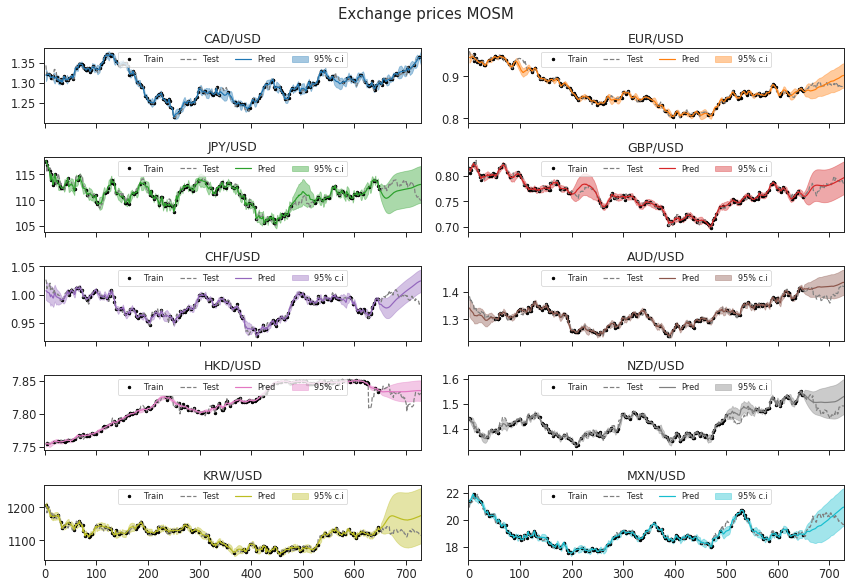

In [17]:
mogptk.plot_prediction(model_mosm, grid=(5, 2), names=cols, title='Exchange prices MOSM');
plt.savefig('output/mosm_exchange_rate.pdf', bbox_inches='tight')

## CSM

In [9]:
n_trials = 5

csm_mae = np.zeros((n_trials, len(cols)))
csm_mape = np.zeros((n_trials, len(cols)))
csm_rmse = np.zeros((n_trials, len(cols)))

for n in range(n_trials):
    model_csm = mogptk.CSM(data, Q=5)
    model_csm.init_params('SM')
    
    print('Starting trial', n)
    model_csm.train(method='L-BFGS-B', maxiter=5000, tol=1e-15)
    print('Finished trial', n)
    print('='*50)
    
    # errors per channel
    error = mogptk.test_errors(model_csm, x_test=x_test, y_test=y_test)
    
    csm_mae[n, :] = np.array(error[0])[:, 0]
    csm_mape[n, :] = np.array(error[0])[:, 1]
    csm_rmse[n, :] = np.array(error[0])[:, 2]

pd.DataFrame(np.c_[csm_mae.mean(0), csm_mape.mean(0), csm_rmse.mean(0),
                             csm_mae.std(0), csm_mape.std(0), csm_rmse.std(0)],
                       columns=['MAE', 'MAPE', 'RMSE', 'MAE std', 'MAPE% std', 'RMSE std'])

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -671.624067
  Number of iterations: 117
  Number of functions evaluations: 212
Done in  0.022541602452596027  minutes
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -645.745911
  Number of iterations: 67
  Number of functions evaluations: 143
Done in  0.018080627918243407  minutes
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: 180.380862
  Number of iterations: 93
  Number of functions evaluations: 142
Done in  0.01796286106109619  minutes
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -624.601646
  Number of iterations: 99
  Number of functions evaluations: 121
Done in  0.017166213194529215  m

,MAE,MAPE,RMSE,MAE std,MAPE% std,RMSE std
0,0.007253,0.560563,0.009372,0.001115,0.087184,0.001544
1,0.007050,0.808709,0.009360,0.000539,0.066061,0.000597
2,0.999718,0.900350,1.328487,0.129933,0.118015,0.157589
3,0.010729,1.397535,0.014643,0.004126,0.529001,0.007226
4,0.008350,0.854623,0.010766,0.000856,0.088000,0.000795
5,0.014657,1.087462,0.022156,0.004030,0.290898,0.010369
6,0.008048,0.102957,0.009773,0.000610,0.007786,0.000694
7,0.018601,1.282906,0.032097,0.007512,0.513575,0.018737
8,9.250801,0.830187,12.284507,2.876465,0.258975,2.910571
9,0.272595,1.415557,0.393833,0.045288,0.236335,0.058687


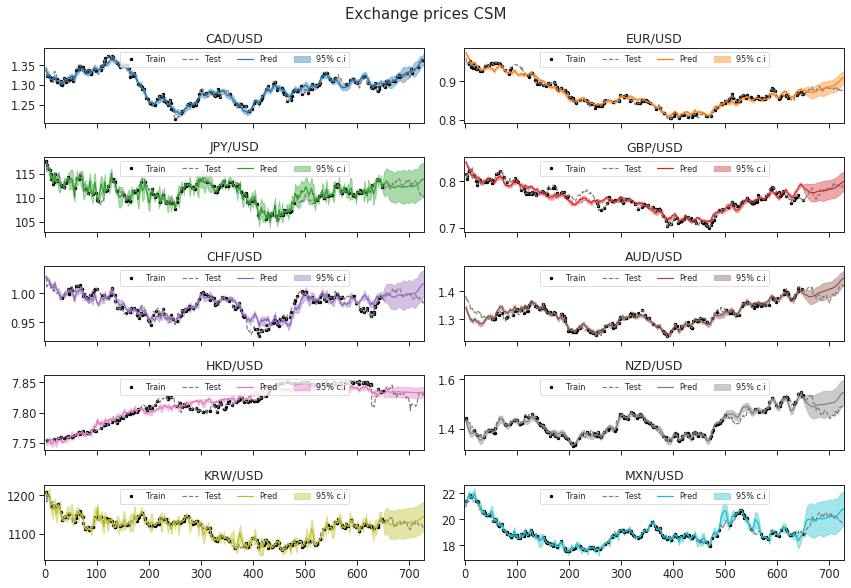

In [10]:
mogptk.plot_prediction(model_csm, grid=(5, 2), names=cols, title='Exchange prices CSM');

## SM-LMC

In [11]:
n_trials = 5

smlmc_mae = np.zeros((n_trials, len(cols)))
smlmc_mape = np.zeros((n_trials, len(cols)))
smlmc_rmse = np.zeros((n_trials, len(cols)))

for n in range(n_trials):
    print('Trial ', n)
    model_smlmc = mogptk.SM_LMC(data, Q=5)
    model_smlmc.init_params('SM')
    
    model_smlmc.train(method='L-BFGS-B', maxiter=5000, tol=1e-50)
    
    error = mogptk.test_errors(model_smlmc, x_test=x_test, y_test=y_test)
    
    smlmc_mae[n, :] = np.array(error[0])[:, 0]
    smlmc_mape[n, :] = np.array(error[0])[:, 1]
    smlmc_rmse[n, :] = np.array(error[0])[:, 2]

pd.DataFrame(np.c_[smlmc_mae.mean(0), smlmc_mape.mean(0), smlmc_rmse.mean(0),
                   smlmc_mae.std(0), smlmc_mape.std(0), smlmc_rmse.std(0)],
             columns=['MAE', 'MAPE%', 'RMSE', 'MAE std', 'MAPE% std', 'RMSE std'])

Trial  0
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -671.624067
  Number of iterations: 117
  Number of functions evaluations: 212
Done in  0.02166306972503662  minutes
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -645.745911
  Number of iterations: 67
  Number of functions evaluations: 143
Done in  0.017487104733784994  minutes
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: 180.380862
  Number of iterations: 93
  Number of functions evaluations: 142
Done in  0.01705823342005412  minutes
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -624.601646
  Number of iterations: 99
  Number of functions evaluations: 121
Done in  0.0160290877024

,MAE,MAPE,RMSE,MAE std,MAPE% std,RMSE std
0,0.008072,0.624377,0.010411,0.000696,0.052937,0.001055
1,0.006511,0.740907,0.008829,0.000328,0.037875,0.000416
2,0.985828,0.886337,1.317399,0.123029,0.110959,0.180019
3,0.008739,1.140756,0.011125,0.000281,0.036049,0.000403
4,0.007771,0.794773,0.010066,0.000515,0.051747,0.000600
5,0.013021,0.973055,0.017497,0.000775,0.055817,0.001360
6,0.007902,0.101088,0.009582,0.000139,0.001784,0.000325
7,0.015562,1.077717,0.022961,0.003032,0.207339,0.006010
8,9.936485,0.889427,12.869623,1.763199,0.157346,2.160141
9,0.188118,0.972421,0.261138,0.022908,0.113498,0.036702


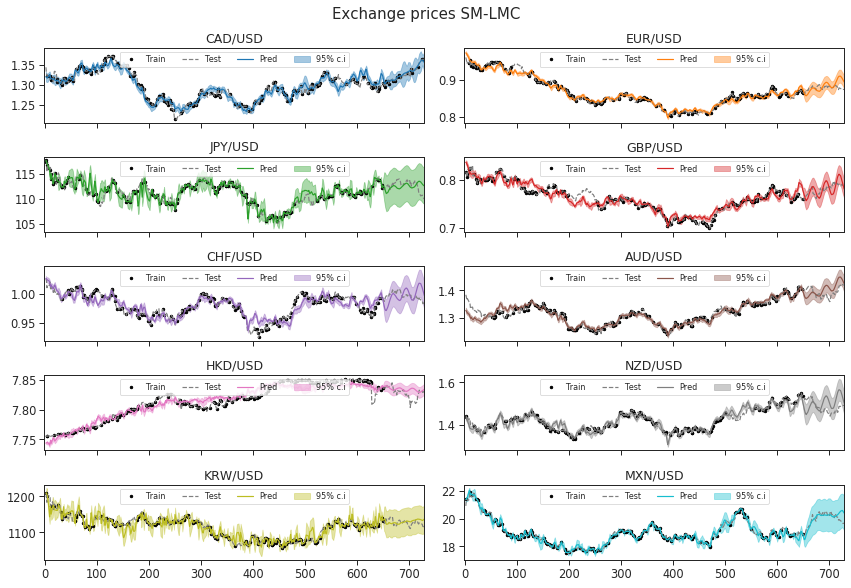

In [12]:
mogptk.plot_prediction(model_smlmc, grid=(5, 2), names=cols, title='Exchange prices SM-LMC');

## Compare All

In [39]:
mosm_mape.mean()

0.5467070024898614

In [13]:
print(mosm_mae[:, 1:].mean(), csm_mae[:, 1:].mean(), smlmc_mae[:, 1:].mean())

0.8923374383591748 1.1767278013579383 1.2411040355893685


In [14]:
print(mosm_mape[:, 1:].mean(), csm_mape[:, 1:].mean(), smlmc_mape[:, 1:].mean())

0.5639225350934965 0.964476155895447 0.8418309995224462


In [15]:
print(mosm_rmse[:, 1:].mean(), csm_rmse[:, 1:].mean(), smlmc_rmse[:, 1:].mean())

1.3402374978032519 1.56729152535179 1.6142466714785364


## IGP
Independant gaussian process with spectral mixture kernel

Q = 4

x_pred = {i:array for i, array in enumerate(data.X_all)}

igp_mae = np.zeros((n_trials, len(cols)))
igp_mape = np.zeros((n_trials, len(cols)))
igp_mse = np.zeros((n_trials, len(cols)))

for n in range(n_trials):    

    for i in range(len(cols)):
        # create data
        data_single = mogptk.Data()
        data_single.add(data.X[i], data.Y[i])
        
        model = mogptk.SM(data_single, Q=Q)
        model.init_params('BNSE')
        model.train(method='L-BFGS-B', maxiter=3000, tol=1e-15)
        
        idx = data.Y_all[i] != 0
        
        y_pred, var_pred = model.predict(x_pred)
        
        igp_mae[n, i] = np.abs(data.Y_all[i] - y_pred[0]).mean() # MAE
        igp_mape[n, i] = np.abs((data.Y_all[i][idx] - y_pred[0][idx]) / data.Y_all[i][idx] * 100).mean() # MAPE
        igp_mse[n, i] = ((data.Y_all[i] - y_pred[0])**2).mean() # MSE